In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
#import functools
#import multiprocessing
#from joblib import Parallel, delayed, pool
#from joblib.pool import has_shareable_memory
from numba import njit


In [2]:
# set Constants
#MATERIAL 1 (concrete)
pRatio1 = 0.15                                     #poission's ratio in 
yModulus1 = 24 * (10**9)                           #youngs modulus in pascals
rho1 = 2400                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter


#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

print('material 1 wave speeds:' ,cl1,ct1)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency




#MATERIAL 2 (iron)
pRatio2=0.3
yModulus2= 200*(10**9)
rho2 = 7800       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = 2 * mu2 * pRatio2 / (1 - 2 * pRatio2)     

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency


#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2
#diensions of material 1 

length1 = 0.30
width1 = 0.30
height1 = 0.150

#dimensions for material 2

length2= 0.1
width2= 0.1
height2= 0.15




material 1 wave speeds: 3249.462449572256 2085.144140570748
material 2 wave speeds: 5875.097044815179 3140.3714651066384


In [3]:
#Run for 6 Cycles:
runtime = 5 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.8732 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) *2       #length 
gw1 = int(math.ceil(width1 / gs)) *2        #width
gh1 = int(math.ceil(height1 / gs)) *2       #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl1, gw1,gh1)


runtime (s), time step size (s), total # of time steps: 0.000125 3.727630869776573e-07 337
grid step size, # of length pts, # of height pts, # of width pts: 0.004344050292855724 140 140 70


In [4]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#defining where the 2nd material lies in the grid
#for now we'll simulate a square rod of material 2 in the middle of a block 
#made up of material 1

gl2 = int(math.ceil(length2 / gs))       
gw2 = int(math.ceil(width2 / gs))         
gh2 = int(math.ceil(height2 / gs))

for x in range(gl1):
    for y in range(gw1):
        if x < y:
            matProps[0,x,y,:]=rho2
            matProps[1,x,y,:]=lmbda2
            matProps[2,x,y,:]=mu2

print('Total # of grid pts, # of material 1 pts, # of material 2 pts:', [gl1*gw1*gh1, gl1*gw1*gh1-8*gl2*gw2*gh2, 8*gl2*gw2*gh2])
print('material 2 indices:')
print('x:',[int(gl1/2)-gl2, int(gl1/2)+gl2])
print('y:',[int(gw1/2)-gw2, int(gw1/2)+gw2])
print('z:', [0, gh2*2])

Total # of grid pts, # of material 1 pts, # of material 2 pts: [1372000, 1210720, 161280]
material 2 indices:
x: [46, 94]
y: [46, 94]
z: [0, 70]


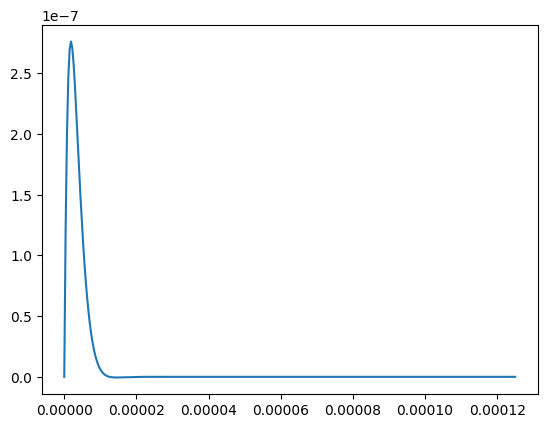

In [5]:
#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 500000
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

plt.figure()
plt.plot(timeVec,sinInputSignal)

plt.ioff()

In [6]:
#boundary values 
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

#initialize fields
vx=np.zeros((gl1,gw1,gh1))
vy=np.zeros((gl1,gw1,gh1))
vz=np.zeros((gl1,gw1,gh1))

sxx=np.zeros((gl1,gw1,gh1))
syy=np.zeros((gl1,gw1,gh1))
szz=np.zeros((gl1,gw1,gh1))
sxy=np.zeros((gl1,gw1,gh1))
sxz=np.zeros((gl1,gw1,gh1))
syz=np.zeros((gl1,gw1,gh1))

#initialize Boundary Conditions
BCs=np.zeros((gl1,gw1,gh1))

#record the signal at a specified location
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vx1Signal=np.zeros(Tsteps)
vy1Signal=np.zeros(Tsteps)
vz1Signal=np.zeros(Tsteps)

vx2Signal=np.zeros(Tsteps)
vy2Signal=np.zeros(Tsteps)
vz2Signal=np.zeros(Tsteps)


In [8]:
def updateStresses(x,y,z):
    
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])

    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
    sxx[x,y,z]=sxx[x,y,z]+ds*ts

    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
    syy[x,y,z]=syy[x,y,z]+ds*ts

    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
    szz[x,y,z]=szz[x,y,z]+ds*ts

    shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
    shearxy=4*(1/gs)*(1/shearDenomxy)
    ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
    sxy[x,y,z]=sxy[x,y,z]+ds*ts

    shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
    shearxz=4*(1/gs)*(1/shearDenomxz)
    ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
    sxz[x,y,z]=sxz[x,y,z]+ds*ts   

    shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
    shearyz=4*(1/gs)*(1/shearDenomyz)
    ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
    syz[x,y,z]=syz[x,y,z]+ds*ts

    #delete variables for updates
    del norm1, norm2


@njit
def FastStressXX(sxxx, Points):
    newStress = np.empty_like(sxx)
    for i in Points:
        norm1=(1/gs)*(matProps[1,i[0],i[1],i[2]]+2*matProps[2,i[0],i[1],i[2]])
        norm2=(1/gs)*(matProps[1,i[0],i[1],i[2]])
        ds=norm1*(vx[i[0],i[1],i[2]]-vx[i[0]-1,i[1],i[2]])+norm2*(vy[i[0],i[1],i[2]]-vy[i[0],i[1]-1,i[2]]+vz[i[0],i[1],i[2]]-vz[i[0],i[1],i[2]-1])
        newStress[i[0],i[1],i[2]]=sxxx[i[0],i[1],i[2]]+ds*ts
    return newStress

@njit
def FastStressYY(syyy, Points):
    newStress = np.empty_like(syyy)
    for i in Points:
        norm1=(1/gs)*(matProps[1,i[0],i[1],i[2]]+2*matProps[2,i[0],i[1],i[2]])
        norm2=(1/gs)*(matProps[1,i[0],i[1],i[2]])
        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        newStress[i[0],i[1],i[2]]=syyy[i[0],i[1],i[2]]+ds*ts
    return newStress

@njit
def FastStressZZ(szzz, Points):
    newStress = np.empty_like(sxx)
    for i in Points:
        norm1=(1/gs)*(matProps[1,i[0],i[1],i[2]]+2*matProps[2,i[0],i[1],i[2]])
        norm2=(1/gs)*(matProps[1,i[0],i[1],i[2]])
        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        newStress[i[0],i[1],i[2]]=szzz[i[0],i[1],i[2]]+ds*ts
    return newStress

@njit
def FastStressXY(sxxy, Points):
    newStress = np.empty_like(sxxy)
    for i in Points:
        shearDenomxy=(1/matProps[2,i[0],i[1],i[2]])+(1/matProps[2,i[0]+1,i[1],i[2]])+(1/matProps[2,i[0],i[1]+1,i[2]])+(1/matProps[2,i[0]+1,i[1]+1,i[2]])
        shearxy=4*(1/gs)*(1/shearDenomxy)
        ds=shearxy*(vx[i[0],i[1]+1,i[2]]-vx[i[0],i[1],i[2]]+vy[i[0]+1,i[1],i[2]]-vy[i[0],i[1],i[2]])
        newStress[i[0],i[1],i[2]]=sxxy[i[0],i[1],i[2]]+ds*ts
    return newStress

@njit
def FastStressXZ(sxxz, Points):
    newStress = np.empty_like(sxxz)
    for i in Points:
        shearDenomxz=(1/matProps[2,i[0],i[1],i[2]])+(1/matProps[2,i[0]+1,i[1],i[2]])+(1/matProps[2,i[0],i[1],i[2]+1])+(1/matProps[2,i[0]+1,i[1],i[2]+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)
        ds=shearxz*(vx[i[0],i[1],i[2]+1]-vx[i[0],i[1],i[2]]+vz[i[0]+1,i[1],i[2]]-vz[i[0],i[1],i[2]])
        newStress[i[0],i[1],i[2]]=sxxz[i[0],i[1],i[2]]+ds*ts
    return newStress

@njit
def FastStressYZ(syyz, Points):
    newStress = np.empty_like(syyz)
    for i in Points:
        shearDenomyz=(1/matProps[2,i[0],i[1],i[2]])+(1/matProps[2,i[0],i[1]+1,i[2]])+(1/matProps[2,i[0],i[1],i[2]+1])+(1/matProps[2,i[0],i[1]+1,i[2]+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)
        ds=shearyz*(vy[i[0],i[1],i[2]+1]-vy[i[0],i[1],i[2]]+vz[i[0],i[1]+1,i[2]]-vz[i[0],i[1],i[2]])
        newStress[i[0],i[1],i[2]]=syyz[i[0],i[1],i[2]]+ds*ts
    return newStress


In [9]:
def updateStressBoundary(x,y,z):
        
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])


    if x!=0 and x!=xmax and y!=0 and y!=ymax:
        shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)

    if x!=0 and x!=xmax and z!=0 and z!=zmax:

        shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)

    if y!=0 and y!=ymax and z!=0 and z!=zmax:

        shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)

    #FACES
    if BCs[x,y,x] == 1:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 5:


        sxx[x,y,x]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif BCs[x,y,x] == 6:
        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif BCs[x,y,x] == 3:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif BCs[x,y,x] == 4:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif BCs[x,y,x] == 2:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0


    #EDGES
    #bottom edges
    elif BCs[x,y,x] == 7:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 8:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,x] == 9:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,x] == 10:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    #side edges
    elif BCs[x,y,x] == 15:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,x] == 17:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 16:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,x] == 18:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #top edges
    elif BCs[x,y,x] == 11:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 12:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 13:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,x] == 14:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #CORNERS

    elif BCs[x,y,x] == 19:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] ==  20:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] ==  21:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 22:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 23:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 24:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] == 25:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,x] ==  26:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    else: print('error:', str(x), str(y), str(z))

In [10]:
def updateVelocity(x,y,z):
    #calculate constants for velocity
    
    dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
    dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
    dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
    
    dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
    vx[x,y,z]=vx[x,y,z]+dv*ts

    dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
    vy[x,y,z]=vy[x,y,z]+dv*ts

    dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
    vz[x,y,z]=vz[x,y,z]+dv*ts

    del dvxConst, dvyConst, dvzConst


In [11]:
def updateVelocityBoundary(x,y,z):
    if x!=xmax:
        dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
        vminx=(2*ts)/(matProps[0,x+1,y,z]*gs)

    if y!=ymax:
        dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
        vminy=(2*ts)/(matProps[0,x,y+1,z]*gs)

    if z!=zmax:
        dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
        vminz=(2*ts)/(matProps[0,x,y,z+1]*gs)
    
    vmax=(2*ts)/(matProps[0,x,y,z]*gs)

    #FACES
    if BCs[x,y,x] == 1:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]


    elif BCs[x,y,x] == 5:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif BCs[x,y,x] == 6:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif BCs[x,y,x] == 3:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif BCs[x,y,x] == 4:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts                     


    elif BCs[x,y,x] == 2:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts


        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]



    #EDGES
    #bottom edges
    elif BCs[x,y,x] == 7:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 8:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 9:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 10:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    #side edges
    elif BCs[x,y,x] == 15:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif BCs[x,y,x] == 17:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif BCs[x,y,x] == 16:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts



    elif BCs[x,y,x] == 18:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    #top edges
    elif BCs[x,y,x] == 11:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif BCs[x,y,x] == 12:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,x] == 13:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif BCs[x,y,x] == 14:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    #CORNERS
    elif BCs[x,y,x] == 19:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 20:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,x] == 21:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 22:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,x] == 23:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 24:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,x] == 25:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,x] == 26:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    else: print('error: ',x,y,z)




In [12]:
def setBCsCube(x,y,z):
 
    #corners
    if x == 0 and y == 0 and z == 0: BCs[x,y,z] = 19
    elif x == 0 and y == 0 and z == zmax: BCs[x,y,z] = 20
    elif x == 0 and y == ymax and z == 0: BCs[x,y,z] = 21
    elif x == 0 and y == ymax and z == zmax: BCs[x,y,z] = 22
    elif x == xmax and y == 0 and z == 0: BCs[x,y,z] = 23
    elif x == xmax and y == 0 and z == zmax: BCs[x,y,z] = 24
    elif x == xmax and y == ymax and z == 0: BCs[x,y,z] = 25
    elif x == xmax and y == ymax and z == zmax: BCs[x,y,z] = 26
    
    #edges
    elif x == 0 and z == 0: BCs[x,y,z] = 7
    elif x == xmax and z == 0: BCs[x,y,z] = 8
    elif y == 0 and z == 0: BCs[x,y,z] = 9
    elif y == ymax and z == 0: BCs[x,y,z] = 10

    elif x == 0 and z == zmax: BCs[x,y,z] = 11
    elif x == xmax and z == zmax: BCs[x,y,z] = 12
    elif y == 0 and z == zmax: BCs[x,y,z] = 13
    elif y == ymax and z == zmax: BCs[x,y,z] = 14

    elif x == 0 and y == 0: BCs[x,y,z] = 15
    elif x == 0 and y == ymax: BCs[x,y,z] = 16
    elif x == xmax and y == 0: BCs[x,y,z] = 17
    elif x == xmax and y == ymax: BCs[x,y,z] = 18

    #faces
    elif z == 0: BCs[x,y,z] = 1
    elif z == zmax: BCs[x,y,z] = 2
    elif y == 0: BCs[x,y,z] = 3
    elif y == ymax: BCs[x,y,z] = 4
    elif x == 0: BCs[x,y,z] = 5
    elif x == xmax: BCs[x,y,z] = 6

def setBCs(mode = 1):
    #definig Boundary Conditions.
    # mode =1 means whole cube
    # mode =2 means rail track

    for x in range(gl1):
        for y in range(gw1):
            for z in range(gh1):
                if mode == 1: setBCsCube(x,y,z)
                


In [13]:
Points = []
BoundaryPoints=[]

for x in range(gl1-1):
    for y in range(gw1-1):
        for z in range(gh1-1):
            if BCs[x,y,z] == 0:
                Points.append([x,y,z])
            else:
                BoundaryPoints.append([x,y,z])


In [14]:
print(np.shape(Points)[0] + np.shape(BoundaryPoints)[0], gl1, gw1, gh1, (gl1-1)*(gw1-1)*(gh1-1))


1333149 140 140 70 1333149


In [15]:
stime = time.time()
jobs = 15

for t in range(0,Tsteps):
    
       
    #sin-exponential input
    vz[inputx,inputy,inputz]=vz[inputx,inputy,inputz]-szzConst*szz[inputx,inputy,inputz]+sinInputSignal[t]
    
    #update Stresses
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateStresses)(i[0],i[1],i[2]) for i in Points)
    #for i in Points: updateStresses(i[0],i[1],i[2])
    sxx = FastStressXX(sxx,Points)
    syy = FastStressXX(syy,Points)
    szz = FastStressXX(szz,Points)
    sxy = FastStressXX(sxy,Points)
    sxz = FastStressXX(sxz,Points)
    syz = FastStressXX(syz,Points)
    for i in BoundaryPoints: updateStressBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")


    #update Velocities
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateVelocity)(i[0],i[1],i[2]) for i in Points)
    for i in Points: updateVelocity(i[0],i[1],i[2])
    for i in BoundaryPoints: updateVelocityBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")
    
        
    #record signals
    vx1Signal[t]=vx[int(signalLocx/2),signalLocy,signalLocz]
    vy1Signal[t]=vy[int(signalLocx/2),signalLocy,signalLocz]
    vz1Signal[t]=vz[int(signalLocx/2),signalLocy,signalLocz]
    
    vx2Signal[t]=vx[int(3*signalLocx/2),signalLocy,signalLocz]
    vy2Signal[t]=vy[int(3*signalLocx/2),signalLocy,signalLocz]
    vz2Signal[t]=vz[int(3*signalLocx/2),signalLocy,signalLocz]
    
    #save vx cut figure
    if t%10==0:
        fig=plt.figure()
        plt.contourf(np.transpose(vz[:,:,int(gh1/2)]), cmap='seismic')
        plt.savefig('images/vzmidCut'+str(t)+'.png')
        plt.close(fig)
    
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)), time.time()-stime)

C:\Users\Dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'Points' of function 'FastStressXX'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\Dan\AppData\Local\Temp\ipykernel_28564\3156358691.py", line 36:
@njit
def FastStressXX(sxxx, Points):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


TypeError: Failed in nopython mode pipeline (step: native lowering)
cannot reflect element of reflected container: reflected list(reflected list(int64)<iv=None>)<iv=None>


In [ ]:
plt.plot(vx1Signal)
plt.plot(vx2Signal)
plt.show()

In [ ]:
plt.plot(vy1Signal)
plt.plot(vy2Signal)
plt.show()

In [ ]:
plt.plot(vz1Signal)
plt.plot(vz2Signal)
plt.show()

In [ ]:
# make animated gif from saved EFIT figures

import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/efitAnim.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)
    

In [ ]:
frame_folder='/sciclone/home20/dchendrickson01/images'

frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]

In [ ]:
frame_one = frames[0]
frame_one.save(f"{frame_folder}/long run efitAnim.gif", format="GIF", append_images=frames,
           save_all=True, duration=300, loop=0)